In [38]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import glob
import sys
import os
import numpy as np
import pandas as pd

import re
from scipy.signal import correlate2d

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import SNOM_Import
import hdf5storage

import scipy.io as sio


In [40]:
sys.path.append('/mnt/c/Users/conor/Git_Projects/PHD')

In [41]:
files = dict()

for i, file_path in tqdm(enumerate(glob.glob("/mnt/c/Users/conor/Git_Projects/PHD/CRUK Grant/*HEADR*")[-100:])):

    file_name = file_path.split('/')[-1].split('HEADR')[0]
    files[file_name] = SNOM_Import.SNOM_File(file_path[:-14])


In [42]:
df = pd.DataFrame({name: vars(file) for name, file in files.items()}).T

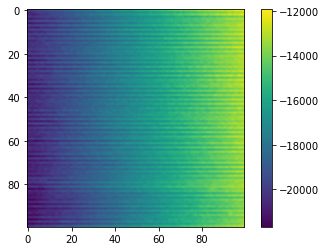

In [43]:
ax=plt.imshow(df.iloc[18].FTOPO)
plt.colorbar(ax)

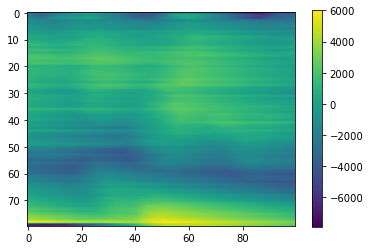

In [44]:
ax=plt.imshow(SNOM_Import.plane_correct(df.iloc[-32].FTOPO[20:,:]))
plt.colorbar(ax)

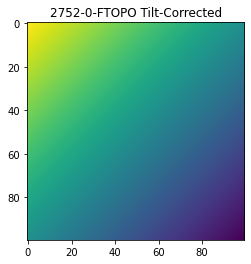

In [45]:
fig, ax1 = plt.subplots(ncols=1)

for i, row in df.iloc[-70:,:].iterrows():

    try:
        ax1.set_title(i+ 'FTOPO Tilt-Corrected')
        ax1.imshow(SNOM_Import.plane_correct(row.FTOPO))

        #fig.savefig(os.path.join(os.getcwd(), 'Tilt_Corrected_Images' ,f"{i}-FTOPO Tilt-Corrected.png"), bbox_inches = 'tight')

    except: pass

In [46]:
df=pd.DataFrame({k:vars(v) for k,v in files.items()}).T

In [47]:
background = pd.read_excel('/mnt/c/Users/conor/Git_Projects/PHD/Human_Insulin_Background_SNOM_Scans_2.xlsx', index_col=0)
df['background_scan'] = background['background_scan']
df['sample']=background['sample']

In [48]:
df.columns

Index(['fileName', 'name', '__HEADR_RAW__', 'number_of_files', 'start_time',
       'end_time', 'pre_scan', 'sample', 'fibre', 'snom_mode', 'scan_rate',
       'afm_gain', 'amplitude', 'frequency', 'vres', 'vref', 'wavenumber',
       'pulse_rate', 'pulse_width', 'time_constant', 'sensitivity',
       'sample_tissue', 'sample_patient', 'sample_slice', 'sample_position',
       'wavelength', 'fel_power', 'scan_size', 'num_points', 'step_size',
       'x-start', 'y-start', 'FTOPO', 'FSNOM', 'BTOPO', 'BSNOM', 'area',
       'operator', '', 'background_scan'],
      dtype='object')

In [49]:
background.loc[:,['sample','background_scan']].sample(10)

,sample,background_scan
2738-0-,C18 on Au,none
2711-0-,C6 on Au with HI pH 2,C6 on Au
2721-0-,C18 on Au with HI pH 2,C18 on Au
2704-0-,C6 on Au with HI pH 2,C6 on Au
2685-0-,C6 on Gold after piranha clean,none
2747-0-,C6 on Au with HI pH 7,C6 on Au
2752-0-,C6 on Au with HI pH 2,C6 on Au
2723-0-,C18 on Au with HI pH 2,C18 on Au
2657-0-,Gold after piranha clean,none
2708-0-,C6 on Au with HI pH 2,C6 on Au


In [50]:
df.shape

(100, 40)

In [51]:
df.loc[:,['sample','wavenumber']].sample(10)

,sample,wavenumber
2672-0-,C18 on Gold after piranha clean,1651 cm-1
2723-0-,C18 on Au with HI pH 2,1689 cm-1
2752-0-,C6 on Au with HI pH 2,1626 cm-1
2724-0-,C18 on Au with HI pH 2,1651 cm-1
2708-0-,C6 on Au with HI pH 2,1689cm-1
2697-0-,C18 on Au with HI pH 7,1626 cm-1
2709-0-,C6 on Au with HI pH 2,1651cm-1
2669-0-,C18 on Gold after piranha clean,1651 cm-1
2714-0-,C18 on Au with HI pH 2,1626cm-1
2734-0-,C6 on Au,1626 cm-1


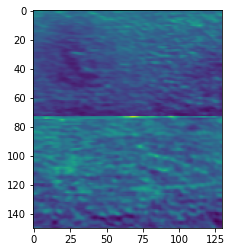

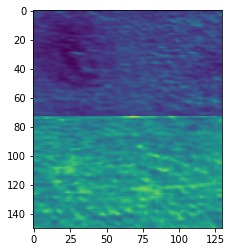

In [52]:
plt.imshow(SNOM_Import.plane_correct(df.loc[:,'FSNOM'][0][:,20:]))
plt.figure()
plt.imshow(df.loc[:,'FSNOM'][0][:,20:])

1626cm-1 C18 on Au
1651cm-1 C18 on Au
1689cm-1 C18 on Au
1626cm-1 C18 on Gold after piranha clean
1651cm-1 C18 on Gold after piranha clean
1689cm-1 C18 on Gold after piranha clean
1626cm-1 C6 on Au
1651cm-1 C6 on Au
1689cm-1 C6 on Au
1626cm-1 C6 on Gold after piranha clean
1651cm-1 C6 on Gold after piranha clean
1689cm-1 C6 on Gold after piranha clean
1626cm-1 Gold after piranha clean
1651cm-1 Gold after piranha clean
1689cm-1 Gold after piranha clean


Text(0.5, 0, 'Pixel Intensity')

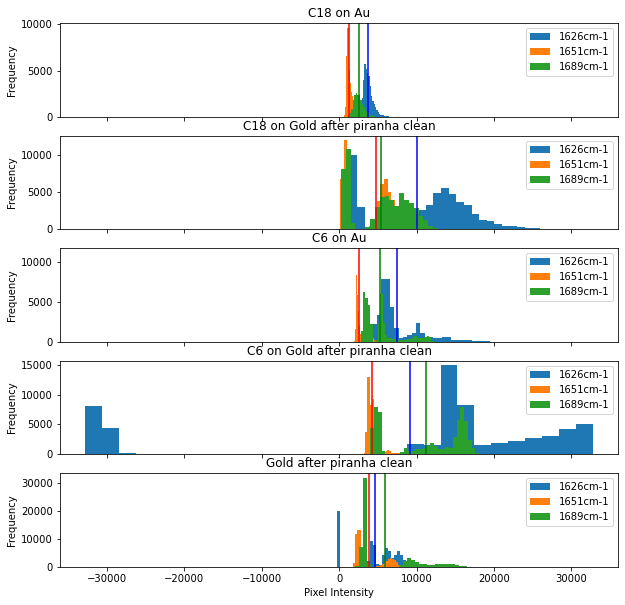

In [58]:
fig, axes = plt.subplots(nrows=5, figsize=(10,10), sharex=True)

# Dictionary containing the expectation value for each 
# total background and each wavelength
bkgs={}

for ax, (name, df_) in zip(axes.flatten(), df.query('background_scan=="none"').groupby('sample')):

    wns={}
    for c, (wn, df_wn) in zip(['b','r','g'], df_.groupby('wavenumber')):

        print(wn.replace(' ',''), name)

        # Extract the sensitivity of the lock in for each image.
        sens = [int(re.search("([0-9]+)", col).groups()[0]) for col in df_wn.sensitivity]

        # Concatenate all of the images together for the current substrate/wavenumber
        fsnom = np.concatenate(df_wn.FSNOM.values*sens)
        bsnom = np.concatenate(df_wn.BSNOM.values*sens)

        total = np.concatenate([fsnom, bsnom])

        hist, bins = np.histogram(total.flatten(), bins=30)
        width = 1.0 * (bins[1] - bins[0])
        center = (bins[:-1] + bins[1:]) / 2

        # Calculate expectation value of distribution
        exp = np.sum(center*(hist/hist.sum()))
        
        # Plot histograms and expectation value
        ax.axvline(exp, c=c)
        ax.hist(total.flatten(), bins=30, label=f'{wn.replace(" ","")}')

        wns[wn.replace(" ","")] = exp
    bkgs[name]=wns

    ax.set_title(f'{name}')
    ax.set_ylabel('Frequency')
    ax.legend()

ax.set_xlabel('Pixel Intensity')

In [54]:
test_images={}

for file_ in tqdm(glob.glob('/mnt/c/Users/conor/Google Drive/PhD/SNOM_Creep_Corrected/*.mat')):

    file_dict = hdf5storage.loadmat(file_)

    for file_name, _file in file_dict.items():

        try:
            snom_file=files[file_name[4:]+'-0-']
            
            sens = int(re.search("([0-9]+)", snom_file.sensitivity).groups()[0])

            bkg_scan=bkgs[df.loc[snom_file.name+'-','background_scan']][snom_file.wavenumber]

            if snom_file.sample == 'C18 on Gold': continue
            

        except:
            continue

        FSNOM = (_file[0][0][0][0]*sens)/bkg_scan
        BSNOM = (_file[0][0][0][1]*sens)/bkg_scan
        FZERO = _file[0][0][0][2]
        BZERO = _file[0][0][0][3]
        FTOPO = _file[0][0][0][4]
        BTOPO = _file[0][0][0][5]

        FSNOM_Tilt_Corrected = SNOM_Import.plane_correct(_file[0][0][0][0])
        BSNOM_Tilt_Corrected = SNOM_Import.plane_correct(_file[0][0][0][1])
        FTOPO_Tilt_Corrected = SNOM_Import.plane_correct(_file[0][0][0][4])
        BTOPO_Tilt_Corrected = SNOM_Import.plane_correct(_file[0][0][0][5])


        data_files={
            'Name': file_name[4:]+'-0-',
            'FSNOM': FSNOM,
            'BSNOM': BSNOM,
            'FZERO': FZERO,
            'BZERO': BZERO,
            'FTOPO': FTOPO,
            'BTOPO': BTOPO,
            'FSNOM_Tilt_Corrected': FSNOM_Tilt_Corrected,
            'BSNOM_Tilt_Corrected': BSNOM_Tilt_Corrected,
            'FTOPO_Tilt_Corrected': FTOPO_Tilt_Corrected,
            'BTOPO_Tilt_Corrected': BTOPO_Tilt_Corrected,
        }

        test_images[file_name[4:]+'-0-'] = data_files

        #print(file_name[4:]+'-0-')

        continue

        file_path = os.path.join(os.getcwd(), 'tilt_corrected_files')
        file_name = file_name+'.mat'

        try: os.mkdir(file_path)
        except: pass

        sio.savemat(os.path.join(file_path, file_name), mdict=data_files)



In [59]:
bkgs

{'C18 on Au': {'1626cm-1': 3765.0019733333334,
  '1651cm-1': 1287.9795733333333,
  '1689cm-1': 2577.60224},
 'C18 on Gold after piranha clean': {'1626cm-1': 10014.116046111112,
  '1651cm-1': 4722.650094444445,
  '1689cm-1': 5382.157862222222},
 'C6 on Au': {'1626cm-1': 7530.176323333333,
  '1651cm-1': 2569.06434,
  '1689cm-1': 5344.499235000001},
 'C6 on Gold after piranha clean': {'1626cm-1': 9130.377913333328,
  '1651cm-1': 4301.919722222222,
  '1689cm-1': 11251.996292222222},
 'Gold after piranha clean': {'1626cm-1': 4644.0133625,
  '1651cm-1': 3821.7330283333336,
  '1689cm-1': 5928.038688888891}}

In [60]:
df['wavenumber']=df.apply(lambda row: row['wavenumber'].replace(' ',''),axis=1)

C18 on Au with HI pH 2 1626cm-1
C18 on Au with HI pH 2 1651cm-1
C18 on Au with HI pH 2 1689cm-1
C18 on Au with HI pH 7 1626cm-1
C18 on Au with HI pH 7 1651cm-1
C18 on Au with HI pH 7 1689cm-1
C6 on Au with HI pH 2 1626cm-1
C6 on Au with HI pH 2 1651cm-1
C6 on Au with HI pH 2 1689cm-1
C6 on Au with HI pH 7 1626cm-1
C6 on Au with HI pH 7 1651cm-1
C6 on Au with HI pH 7 1689cm-1


Text(0.5, 0, 'Pixel Intensity')

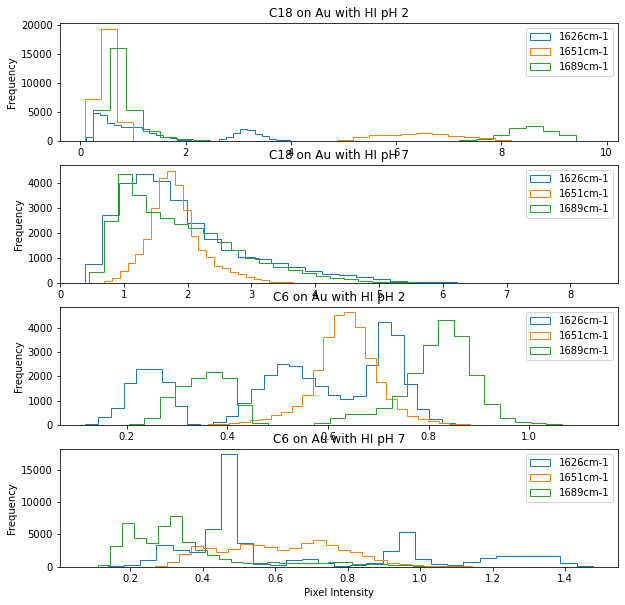

In [64]:
fig, axes = plt.subplots(nrows=4, figsize=(10,10), sharex=False)


for ax, (name, df_) in zip(axes.flatten(), df.iloc[11:-1,:].query("background_scan!='none'").groupby('sample')):

    wns={}

    for c, (wn, df_wn) in zip(['b','r','g'], df_.groupby('wavenumber')):

        print(name, wn)

        # Extract the sensitivity of the lock in for each image.
        sens = [int(re.search("([0-9]+)", col).groups()[0]) for col in df_wn.sensitivity]

        total=[]

        bkg = bkgs[df_wn.background_scan[0]][wn]

        #fsnom = np.concatenate(df_wn.FSNOM.values*sens)
        #bsnom = np.concatenate(df_wn.BSNOM.values*sens)

        try:
            # Concatenate all of the images together for the current substrate/wavenumber
            try:
                #fsnom = np.concatenate(df_wn.FSNOM.values*sens)
                total.append(np.concatenate((df_wn.FSNOM.values*sens/bkg)))
            except:
                total.append(np.concatenate(df_wn.BSNOM.values*sens/bkg))
            #bsnom = np.concatenate(df_wn.BSNOM.values*sens)
        except: 
            continue

        total = np.concatenate(total)

        ax.hist(total.flatten(), bins=30, label=f'{wn.replace(" ","")}', histtype='step')

    ax.set_title(f'{name}')
    ax.set_ylabel('Frequency')
    ax.legend()

ax.set_xlabel('Pixel Intensity')

In [223]:
def cross_correlate(f,b):

    corr=correlate2d(f, b)

    new_i = np.unravel_index(corr.argmax(), corr.shape)

    fb=np.max([f.shape, b.shape], axis=0)

    output=np.zeros(fb)

    output[0:f.shape[0],0:f.shape[1]] = f
    output[-b.shape[0]:,-b.shape[1]:] = (output[-b.shape[0]:,-b.shape[1]:] + b)/2

    return output


In [177]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.imshow(corr-(corr-center[exp_i]))
ax2.imshow(corr-center[exp_i])

NameError: name 'corr' is not defined

-2467638932.213867
(0, 7)


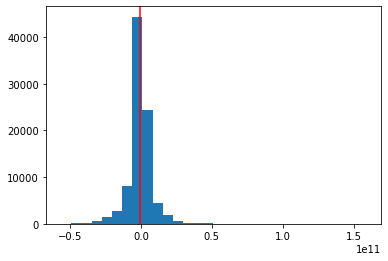

In [181]:
hist, bins = np.histogram(corr.flatten(), bins=30)
width = 1.0 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

exp = np.sum(center*(hist/hist.sum()))
exp_i=np.argmin([exp-bin for bin in hist])
print(center[exp_i])

print(np.unravel_index(exp_i, corr.shape))

#plt.plot([bin-exp for bin in hist])
plt.axvline(exp,c='r')

plt.bar(center, hist, align='center', width=width)
plt.show()

F((150, 150))
B((150, 150))
O((150, 150))


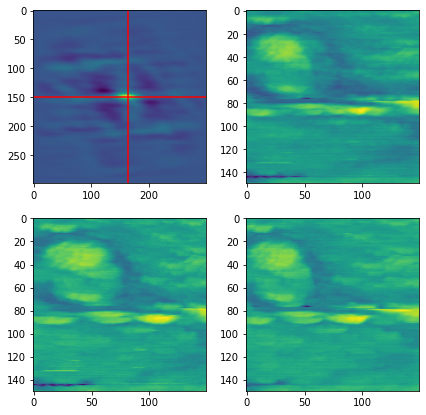

In [179]:
#corr[40:60, 80:100] = 0
#

name = '2720-0-'
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(ncols=2,nrows=2,figsize=(7,7))

f=SNOM_Import.plane_correct(df.iloc[2].FTOPO)
#f=df.iloc[2].FSNOM
b=SNOM_Import.plane_correct(df.iloc[2].BTOPO)
#b=df.iloc[2].BSNOM

output=cross_correlate(f, b)
corr=correlate2d(f, b)
new_i = np.unravel_index(corr.argmax(), corr.shape)

ax1.imshow(corr)
ax1.axhline(new_i[0],c='r')
ax1.axvline(new_i[1],c='r')

ax2.imshow(output)
ax3.imshow(f)
ax4.imshow(b)

print(f'F({f.shape})')
print(f'B({b.shape})')
print(f'O({output.shape})')

In [211]:
fig, axes = plt.subplots(ncols=2, nrows=4)

for index, row in df.iterrows():

        im_file=row

        ftopo = im_file.FTOPO
        fsnom = im_file.FSNOM

        plane = plane_correct(ftopo)

        plane_n = (plane)/plane.max()
        fsnom_n = (fsnom)/fsnom.max()

        print(im_file.fileName)

        continue

        data = {'FTOPO': im_file.FTOPO,
                'BTOPO': im_file.BTOPO,
                'FSNOM': im_file.FSNOM,
                'BSNOM': im_file.BSNOM,
                'FTOPO_Tilt_corrected': im_file.FTOPO-plane_correct(im_file.FTOPO),
                'BTOPO_Tilt_corrected': im_file.BTOPO-plane_correct(im_file.BTOPO),
                'FSNOM_Tilt_corrected': im_file.FSNOM-plane_correct(im_file.FSNOM),
                'BSNOM_Tilt_corrected': im_file.BSNOM-plane_correct(im_file.BSNOM)}


        os.makedirs(os.path.getcwd(), )

        savemat(os.path.join(os.getcwd(), 'test.mat'), data)

        for ax, (title, im) in zip(axes.flatten(), data.items()):

                ax.imshow(im)
                ax.set_title(title) 

NameError: name 'plane_correct' is not defined